# FinnSentiment

Neural Network implementation of sentiment analysis using **FinnSentiment** dataset from 'url'

## 1. Binary Classifier
In this section, we will consider only 2 polarities of the comments: **positive** and **negative**.


In [41]:
%pip install numpy
%pip install matplotlib
%pip install nltk

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [42]:
#import essential libraries for the project
import numpy as np
import matplotlib.pyplot as plt

from string import punctuation

import nltk
from nltk.tokenize import word_tokenize

%matplotlib inline


In [43]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Windows\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [44]:
print('\nPunctuation\n')
print(punctuation)


Punctuation

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [45]:
# example of how to use word_tokenize
word_tokenize('I am a girl.')

['I', 'am', 'a', 'girl', '.']

In [46]:
# function to read data from a file
def process_data(datatype, language, label):
    '''
        input
        - datatype: 'train' or 'test'
        - language: 'en'(English) or 'fi'(Finnish)
        - label: 'pos'(positive) or 'neg'(negative)
        output
        - list of sentences
    '''
    filename = label + '_test.txt' if datatype=='test' else label + '.txt'
    filepath = 'data-raw/bin/' + language + '/' + datatype + '/' + filename

    with open(filepath, mode='r', encoding='utf8') as f:
        sentences = f.readlines()

    # -------------------------------------------------- data preprocessing  -------------------------------------------------- #
    data = []
    
    for sentence in sentences:
        sentence = sentence.lower() # lowercase
        sentence = sentence.replace('\n','') # remove \n  

        words = word_tokenize(sentence) # tokenisation

        # remove stop words and punctuations
        for word in words:
            if (word in list(punctuation)): 
                words.remove(word)
                
        # append list of words of a sentence to data
        data.append(words)
    # -------------------------------------------------- data preprocessing  -------------------------------------------------- #
    
    return data


In [47]:
# data preprocessing: get list of words for each sentence
train_pos = process_data('train','fi','pos')
train_neg = process_data('train','fi','neg')
test_pos = process_data('test','fi','pos')
test_neg = process_data('test','fi','neg')

for words in test_pos[0:10]: print(words)

['voisimmeko', 'mennä', 'lasilliselle']
['tekeekö', 'mielesi', 'italialaista']
['taidat', 'tykätä', "beaujolais'tä", 'vai', 'mitä']
['onko', 'löytänyt', 'täydellisen', 'naisesi']
['älä', 'aloita', 'ilman', 'minua']
['vai', 'ei', 'poikakaveria', '...']
['miten', 'se', 'sujui']
['mennään', 'sänkyyn']
['soita', 'minulle', 'parin', 'päivän', 'päästä']
['käydään', 'serkkuni', 'luona']


<BarContainer object of 2 artists>

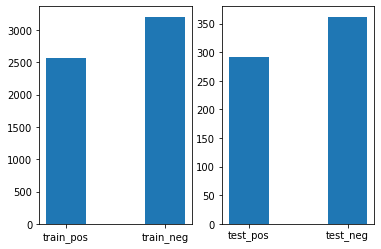

In [48]:
# training, testing data visualisation

labels_train = 'train_pos', 'train_neg'
sizes_train = [len(train_pos), len(train_neg)] 
plt.subplot(1, 2, 1)
plt.bar(labels_train, sizes_train, width = 0.4)

labels_test = 'test_pos', 'test_neg'
sizes_test = [len(test_pos), len(test_neg)] 
plt.subplot(1, 2, 2)
plt.bar(labels_test, sizes_test, width = 0.4)


In [49]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [50]:
# hello pytorch!!
import torch

data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)
print('PyTorch run successfully!' if type(x_data) == torch.Tensor else 'FAILED!')

PyTorch run successfully!
